<a href="https://colab.research.google.com/github/ankitashrivastav12/ML-MODELS/blob/main/Brain_dataset_Final_Hybrid_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikeras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import QuantileTransformer


In [ ]:
# Step 1: Data Acquisition
# Load the dataset
file_path = '/content/drive/MyDrive/Research papers and datasets/paper1/Brain_GSE50161.csv'
data = pd.read_csv(file_path)

# Display the first few rows and columns of the dataset
print(data.head())
print("Columns in the dataset:", data.columns)


   samples        type  1007_s_at   1053_at     117_at    121_at  1255_g_at  \
0      834  ependymoma  12.498150  7.604868   6.880934  9.027128   4.176175   
1      835  ependymoma  13.067436  7.998090   7.209076  9.723322   4.826126   
2      836  ependymoma  13.068179  8.573674   8.647684  9.613002   4.396581   
3      837  ependymoma  12.456040  9.098977   6.628784  8.517677   4.154847   
4      838  ependymoma  12.699958  8.800721  11.556188  9.166309   4.165891   

    1294_at   1316_at   1320_at  ...  AFFX-r2-Ec-bioD-3_at  \
0  7.224920  6.085942  6.835999  ...              9.979005   
1  7.539381  6.250962  8.012549  ...             11.924749   
2  7.813101  6.007746  7.178156  ...             12.154405   
3  8.361843  6.596064  6.347285  ...             11.969072   
4  7.923826  6.212754  6.866387  ...             11.411701   

   AFFX-r2-Ec-bioD-5_at  AFFX-r2-P1-cre-3_at  AFFX-r2-P1-cre-5_at  \
0              9.926470            12.719785            12.777792   
1             

In [ ]:
# 2.1 Quantile Normalization
qt = QuantileTransformer()
data_normalized = pd.DataFrame(qt.fit_transform(data.drop(columns=['type'])), columns=data.columns[1:])
data_normalized['type'] = data['type']

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2824: UserWarning: n_quantiles (1000) is greater than the total number of samples (130). n_quantiles is set to n_samples.
  warnings.warn(


In [ ]:
# Step 3: Data Splitting
X = data_normalized.drop(columns=['type']).values
y = data_normalized['type']

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Print total number of features
total_features = X.shape[1]
print(f"Total number of features: {total_features}")


Total number of features: 54675


In [ ]:
# Step 4: Feature Selection
# Feature selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances and select top 500 features
importances = rf.feature_importances_
n_top_features = 500
important_feature_indices = np.argsort(importances)[-n_top_features:]

# Print total number of selected features
print(f"Total number of selected features: {n_top_features}")
training_feature_names = data_normalized.columns[1:][important_feature_indices]  # Exclude 'type' column


# Print sample of selected feature indices
sample_indices = important_feature_indices[:10]  # Show the first 10 selected feature indices
print("Sample of selected feature indices:", sample_indices)

# Select important features for training and testing sets
X_train_selected = X_train[:, important_feature_indices]
X_test_selected = X_test[:, important_feature_indices]



Total number of selected features: 500
Sample of selected feature indices: [20135 23117 45306 13983 39438 39785 37594 37834 27074 28880]


In [ ]:
imputer = SimpleImputer(strategy='mean')
X_train_selected = imputer.fit_transform(X_train_selected)
X_test_selected = imputer.transform(X_test_selected)

In [ ]:
# Step 5: Regularization Techniques
scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

In [ ]:
# Step 6: Model Development
# Set dimensions
input_dim = X_train_selected.shape[1]
latent_dim = 64

# Define the autoencoder generator
input_layer = Input(shape=(input_dim,))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(latent_dim, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded_output = Dense(input_dim, activation='sigmoid')(decoded)

generator = Model(inputs=input_layer, outputs=decoded_output, name="Generator")
generator.compile(optimizer='adam', loss='mse')

# Define the discriminator
discriminator_input = Input(shape=(input_dim,))
x = Dense(256)(discriminator_input)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(128)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, x, name="Discriminator")
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Combined GAN model (autoencoder + discriminator)
discriminator.trainable = False
gan_input = generator.input
gan_output = discriminator(generator.output)

# Create and compile the model
gan = Model(gan_input, gan_output, name="GAN")
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
# Step 7: Model Training
batch_size = 64
epochs = 50
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, X_train_selected.shape[0], batch_size)
    real_samples = X_train_selected[idx]
    fake_samples = generator.predict(real_samples)

    d_loss_real = discriminator.train_on_batch(real_samples, real)
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    g_loss = gan.train_on_batch(real_samples, real)

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, Discriminator Loss: 0.6799436807632446, Generator Loss: [array(0.73983026, dtype=float32), array(0.73983026, dtype=float32), array(0.3125, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 10, Discriminator Loss: 0.7772668600082397, Generator Loss: [array(0.7858797, dtype=float32), array(0.7858797, dtype=float32), array(0.30894887, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 20, Discriminator Loss: 0.9535633325576782, Generator Loss: [array(0.9707109, dtype=float32), array(0.970

In [ ]:
# Extract encoded features from generator's encoder part
encoder = Model(inputs=input_layer, outputs=encoded)
X_train_encoded = encoder.predict(X_train_selected)
X_test_encoded = encoder.predict(X_test_selected)

# Build Classification Model using Encoded Features
classifier = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_encoded.shape[1],)),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile the classification model
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert y_train to one-hot encoded format
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, num_classes=5) # Assuming you have 5 classes
history=classifier.fit(X_train_encoded, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 936ms/step - accuracy: 0.1032 - loss: 3.9891 - val_accuracy: 0.3810 - val_loss: 2.5063
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1387 - loss: 2.7819 - val_accuracy: 0.3810 - val_loss: 1.8522
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2040 - loss: 2.0253 - val_accuracy: 0.3810 - val_loss: 1.4212
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4583 - loss: 1.6270 - val_accuracy: 0.6667 - val_loss: 1.2059
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5779 - loss: 1.2453 - val_accuracy: 0.6667 - val_loss: 1.1480
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5289 - loss: 1.1384 - val_accuracy: 0.6667 - val_loss: 1.1384
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5626 - loss: 1.0390 - val_accuracy: 0.6667 - val_loss: 1.0900
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6875 - loss: 0.9001 - val_accuracy: 0.5714 - val_loss: 1.0280
Epoch 9/50

In [ ]:
# Step 8: Model Evaluation
y_pred = classifier.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred, axis=1) # Get predicted class for each sample

# Calculate accuracy and log loss
accuracy = accuracy_score(y_test, y_pred_classes)
logloss = log_loss(y_test, y_pred)

# Output the results
print(f'Accuracy: {accuracy}')
print(f'Log Loss: {logloss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
Accuracy: 0.8846153846153846
Log Loss: 0.35485628591207974


In [ ]:
# Step 10: Final Testing and Validation
# Create a final test dataset by splitting the original dataset
final_test_data, final_train_data = train_test_split(data_normalized, test_size=0.8, random_state=42)

# Save the final test dataset
final_test_file_path = '/content/drive/MyDrive/Colab Notebooks/Project Group 28/Brain_Final_Test.csv'
final_test_data.to_csv(final_test_file_path, index=False)


In [ ]:
# Step 11: Preprocess the Final Test Dataset
# Drop 'type' column to focus on features only
X_final_test = final_test_data.drop(columns=['type']).copy()

# Re-align to match the training feature names exactly
X_final_test_aligned =X_final_test.iloc[:, important_feature_indices].values

# Apply imputation, scaling, and feature selection
X_final_test_imputed = imputer.transform(X_final_test_aligned)
X_final_test_scaled = scaler.transform(X_final_test_imputed)


In [ ]:
# Step 12: Final Testing and Validation
X_final_test_encoded = encoder.predict(X_final_test_scaled)
y_final_pred = classifier.predict(X_final_test_encoded)
y_final_pred_classes = np.argmax(y_final_pred, axis=1)

# Calculate final accuracy
y_final_test = label_encoder.transform(final_test_data['type'])
final_accuracy = accuracy_score(y_final_test, y_final_pred_classes)
print(f"Final Test Accuracy: {final_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Final Test Accuracy: 0.9615


In [ ]:
pip install --upgrade scikeras scikit-learn
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define a function to build the classifier model
def build_classifier():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_final_test_encoded.shape[1],)),
        Dense(32, activation='relu'),
        Dense(5, activation='softmax')
    ])
    # Use sparse_categorical_crossentropy to handle integer labels
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model in KerasClassifier
classifier = KerasClassifier(model=build_classifier, epochs=50, batch_size=32, verbose=0)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(classifier,X_train_encoded,y_train, cv=cv, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


SyntaxError: invalid syntax (<ipython-input-21-6824a120e805>, line 1)

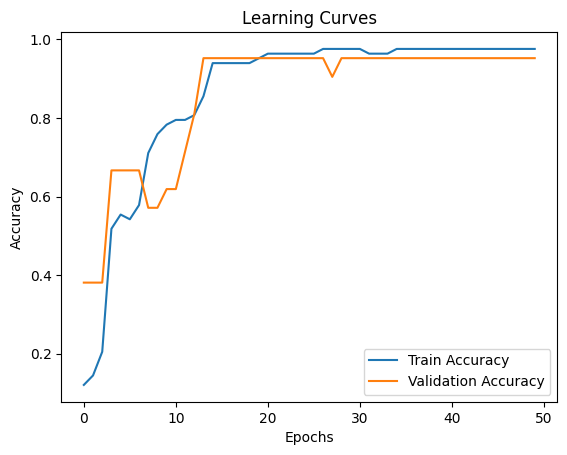

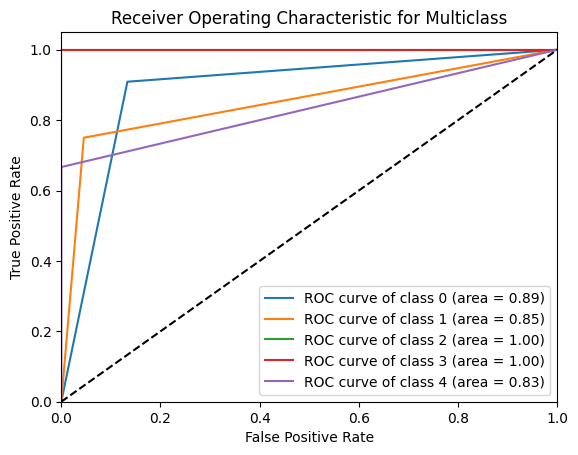

In [ ]:
# Step 13: Results Reporting
# Plot learning curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Plot ROC curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.arange(5))  # Assuming 5 classes
y_pred_bin = label_binarize(np.argmax(y_pred, axis=1), classes=np.arange(5))

# Compute ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(5):  # Assuming 5 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()


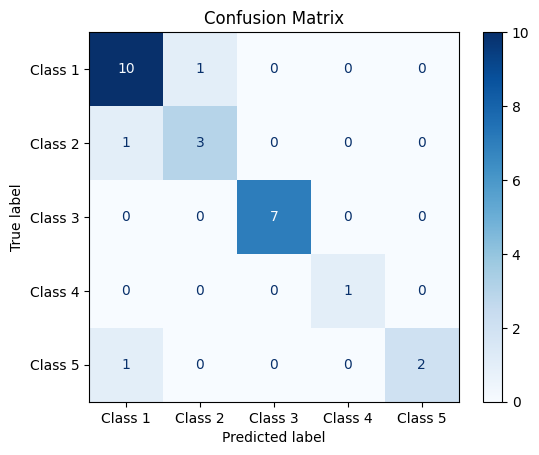

Classification Report:
              precision    recall  f1-score   support

     Class 1       0.83      0.91      0.87        11
     Class 2       0.75      0.75      0.75         4
     Class 3       1.00      1.00      1.00         7
     Class 4       1.00      1.00      1.00         1
     Class 5       1.00      0.67      0.80         3

    accuracy                           0.88        26
   macro avg       0.92      0.87      0.88        26
weighted avg       0.89      0.88      0.88        26



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the following variables from your model evaluation:
# y_test: True labels of the test dataset
# y_pred_classes: Predicted labels from the model (e.g., using np.argmax(y_pred, axis=1))

# Step 1: Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Step 2: Display the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Optional: Print a Classification Report for additional metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']))
